In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.nn import functional as F
import tqdm
from src import models, utils, parametrizations,tasks,running,tasks
import os 

%load_ext autoreload
%autoreload 2

plt.rcParams.update({
    'font.size': 16,  # Update global font size
    'axes.titlesize': 20,  # Update axes title font size
    'axes.labelsize': 10,  # Update axes label font size
    'xtick.labelsize': 12,  # Update xtick label font size
    'ytick.labelsize': 12,  # Update ytick label font size
})

In [4]:

def generate_sine_waves(n, T, frequency=1, time_step=0.01):
    t = np.arange(0, T, time_step)
    matrix = np.zeros((n, len(t)))

    for i in range(n):
        amplitude = np.random.uniform(0.5, 1.0)
        phase = np.random.uniform(0, 2 * np.pi)
        matrix[i, :] = amplitude * np.sin(2 * np.pi * frequency * t + phase)

    return t, matrix

  


def plot_simulation_results(t, sine_waves, state):
    n = sine_waves.shape[0]
    
    plt.figure(figsize=(10, 5))
    for i in range(n):
        plt.plot(t, sine_waves[i, :], label=f'Input sine wave {i+1}')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.title('Sine waves input')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 5))
    for i in range(n):
        plt.plot(t, state[i, :], label=f'State {i+1}')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.title('System state')
    plt.legend()
    plt.show()



In [5]:
class GW_Net:
    def __init__(self, hidden_size = 32, p = 5, g = 1.5, s_max = 1):
        self.hidden_size = hidden_size
        self.p = p
        self.g = g 
        self.s_max = s_max
        self.build_GW_Net()
        
        
    def build_GW_Net(self):
        # hidden_size = number of units per subnetwork
        # p = number of subnetworks
        # g = initial recurrent magnitude for h2h matrices
        # s_max = largest singular value of h2h matrices

        ns = [self.hidden_size for _ in range(self.p)]

        A_tril = torch.zeros((len(ns), len(ns)))
        A_tril[-1, :] = 1

        X = np.random.normal(0,1/np.sqrt(self.hidden_size),sum(ns))


        # mask to define interareal connectivity
        B_mask = utils.create_mask_given_A(A_tril, ns)
        B = B_mask.detach().cpu().numpy()
        B = 0.5*(B + B.T)
        B[B == 1] = 0

        # fixed interareal weights
        F = B*X - (B*X).T

        # adaptable weights
        A = np.eye(int(self.hidden_size*self.p))#np.random.normal(0,1/np.sqrt(hidden_size),(sum(ns),sum(ns)))
        A = A*B

        # intra-areal weights, singular values less than or equal to unity
        blocks = utils.create_mask_given_A(np.eye(len(ns)), ns)
        blocks = blocks.detach().cpu().numpy()
        W = np.random.normal(0,self.g/np.sqrt(self.hidden_size),(sum(ns),sum(ns)))
        W *= blocks

        # sparsify h2h weights
        random_W_mask = np.random.choice([0,1],p = [0.8,0.2],size = (sum(ns),sum(ns)))
        W *= random_W_mask

        # project h2h to unit norm
        u,s,vt = np.linalg.svd(W)
        s = np.minimum(self.s_max,s)
        W = u @ np.diag(s) @ vt

        self.W, self.F, self.A, self.B = W, F, A, B

    def forward(self, x, u):
        # Define the forward computation here
        
        return -x + self.W @ np.maximum(0,x) + self.F @ x + self.A @ x + u

    def __call__(self, x, u):
        return self.forward(x, u)



In [10]:
eeg_train = np.load('/om2/user/leokoz8/code/rnns-of-rnns/data/EEG_train.npy')

def run_adaptation_EEG(net = None, hidden_size = 16, p = 4, dt = 0.005, T = 150,trials = 1 ,eta = 1):

    n = int(hidden_size*p)
    ts = np.arange(0, T, dt)


    es = np.zeros((trials,len(ts)))



    for trial in range(trials):
        x = np.random.normal(0, 1, n)

        #_, sine_waves = generate_sine_waves(n, T, time_step= dt, frequency = 5)
        
        #_, sine_waves_desired = generate_sine_waves(n, T, time_step = dt, frequency = 1)
        
        #P = np.random.normal(0,1/np.sqrt(n),size = (n,1))
        #sine_waves_desired = P @ sine_wave_desired
        
        states = []

        for k,t in enumerate(ts):
            
            states.append(x)

            e = x - eeg_train[k,:]
            es[trial,k] = (1/np.sqrt(n))*np.linalg.norm(e)

            net.A = net.A - dt*eta*np.outer(e,x)*net.B


            f = net(x, - e)

            x = x +  dt*f

        states = np.stack(states)
        #outputs = states @ P
        
        #output_errors = outputs - sine_wave_desired
        #es_output = np.linalg.norm(output_errors,axis = 1)
        
    
    return es, states#, outputs, es_output
    

In [9]:
GW_RNN_Stable = GW_Net(hidden_size = 16, p = 4,g = 1.5, s_max = 1)
es,states = run_adaptation_EEG(net = GW_RNN_Stable, T = 150)

NameError: name 'sine_waves' is not defined

In [240]:
def run_adaptation(net = GW_RNN, hidden_size = 32, p = 5, dt = 0.005, T = 150,trials = 1 ,eta = 1):

    n = int(hidden_size*p)
    ts = np.arange(0, T, dt)


    es = np.zeros((trials,len(ts)))



    for trial in range(trials):
        x = np.random.normal(0, 1, n)

        _, sine_waves = generate_sine_waves(n, T, time_step= dt, frequency = 5)
        
        _, sine_waves_desired = generate_sine_waves(n, T, time_step = dt, frequency = 1)
        
        #P = np.random.normal(0,1/np.sqrt(n),size = (n,1))
        #sine_waves_desired = P @ sine_wave_desired
        states = []

        for k,t in enumerate(ts):
            
            states.append(x)

            e = x - sine_waves_desired[:,k]
            es[trial,k] = (1/np.sqrt(n))*np.linalg.norm(e)

            net.A = net.A - dt*eta*np.outer(e,x)*net.B


            f = net(x, sine_waves[:,k] - e)

            x = x +  dt*f

        states = np.stack(states)
        #outputs = states @ P
        
        #output_errors = outputs - sine_wave_desired
        #es_output = np.linalg.norm(output_errors,axis = 1)
        
    
    return es, states#, outputs, es_output
    

In [241]:
GW_RNN_Stable = GW_Net(g = 1.5, s_max = 1)
es,states = run_adaptation(net = GW_RNN_Stable, T = 150)

(0.0, 1.1478849461232237)

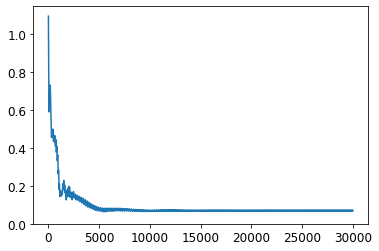

In [243]:
#mean_stable = np.mean(es, axis = 0)
#plt.plot(mean_stable);
plt.plot(np.mean(es,axis = 0))
plt.ylim(0)

Text(0.5, 1.0, 'Instability vs. Performance Error')

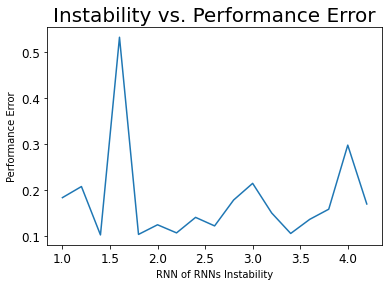

In [98]:
plt.plot(gs,perf_index)
plt.ylabel('Performance Error')
plt.xlabel('RNN of RNNs Instability')
plt.title('Instability vs. Performance Error')

In [83]:
np.mean(es_stable)

0.05304771179110923

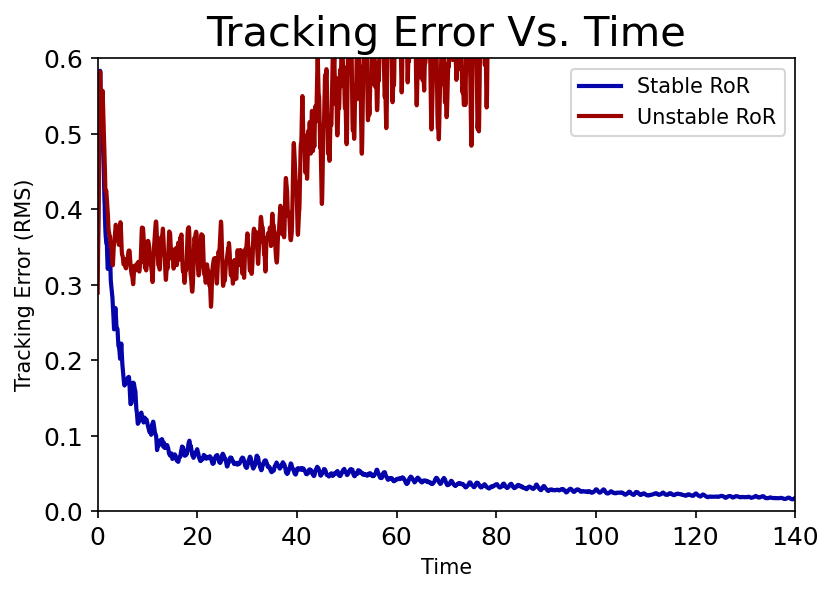

In [81]:
fig = plt.figure(dpi = 150)

win = int(1/dt)

mean_unstable = np.mean(es_unstable, axis = 0)
mean_stable = np.mean(es_stable, axis = 0)

smooth_error_unstable = np.convolve(mean_unstable, np.ones(win)/(win), mode='same')
smooth_error = np.convolve(mean_stable, np.ones(win)/(win), mode='same')


standard_error = np.std(es, axis = 0)#/np.sqrt(trials)

plt.plot(ts, smooth_error, color = '#0504aa', linewidth = 2, label = 'Stable RoR');
plt.plot(ts, smooth_error_unstable, color = '#9a0200', linewidth = 2, label ='Unstable RoR');
#plt.fill_between(ts, mean - standard_error, mean + standard_error, alpha=0.8, label='Standard Deviation')

plt.ylim(0,0.6);
plt.xlim(ts[0],140);
plt.xlabel('Time')
plt.ylabel('Tracking Error (RMS)')
plt.title('Tracking Error Vs. Time')
plt.legend(fontsize = 10)

#plt.savefig('stable_vs_unstable_error_vs_time_sine_task.png', dpi = 300)



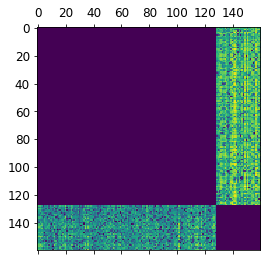

In [585]:
plt.matshow(np.log(np.abs(A) + 0.01))

In [594]:
eigs,_ = np.linalg.eig(A)
np.max(np.real(eigs))

3.1450188963023535

In [487]:
eigs,_ = np.linalg.eig(-np.eye(n) + W_unstable + L)
np.max(np.real(eigs))

-0.31523217122724645

In [ ]:


input_size = env.observation_space.shape[0]
output_size = env.action_space.n

A_tril = torch.zeros((len(ns), len(ns)))
A_tril[-1, :] = 1

B_mask = create_mask_given_A(A_tril, ns)

if interareal_constraint == "None":
    # No stability constraint on interareal weights
    B_mask = 0.5 * (B_mask + B_mask.T)
    M_hat = torch.eye(sum(ns), device=device)

if interareal_constraint == "conformal":
    # Stability constraint on interareal weights, conformal to the stability constraint on the subnetworks

    if c_type == "spectral":
        M_hat = torch.eye(sum(ns), device=device)

    if c_type == "sym" or c_type == "None":
        with torch.no_grad():
            Ms = compute_metric_from_weights(
                stacked_wb["rnn_h2h_weight"], ctype=c_type, device=device
            )
            M_hat = torch.block_diag(*Ms)

B_mask = F.dropout(B_mask, 0.5)

# Create global workspace weights and biases here
W_hat, Ws = create_random_block_stable_symmetric_weights([gw_hidden_size])
W_hat = W_hat.to(device)
tmp = nn.Linear(gw_hidden_size, gw_hidden_size, bias=True, device=device)
b_hat = tmp.bias

stacked_wb["rnn_h2h_weight"].append(W_hat)
stacked_wb["rnn_h2h_bias"].append(b_hat)